In [199]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, Normalizer
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_validate


import os
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
from src.models.predict_model import predict_proba_score, predict_proba_, plot_feature_importance
from src.data.location_notebook import get_location

In [201]:
(DATA_DIR, DATA_DIR_PROCESSED, 
INTERMEDIATE_RESULTS, GROUP_INTERMEDIATE_RESULTS, 
CLEANED_DS , TRAIN_RAW_FILE, 
VALIDATION_RAW_FILE, TEMPLATE_SUBMIT) = get_location()

In [202]:
df_train = pd.read_parquet(INTERMEDIATE_RESULTS)

In [203]:
df_train.has_contract.value_counts()

1.0    11312
0.0     8186
Name: has_contract, dtype: int64

In [204]:
df_train.columns[~df_train.columns.str.contains("Product_Name|Product_Family")].tolist()

['Pricing, Delivery_Terms_Quote_Appr',
 'Pricing, Delivery_Terms_Approved',
 'Bureaucratic_Code_0_Approval',
 'Bureaucratic_Code_0_Approved',
 'Opportunity_ID',
 'TRF',
 'Total_Taxable_Amount',
 'train',
 'has_contract',
 'rate',
 'Total_Amount_Imputed',
 'Territory_Imputed',
 'Planned_Range_days',
 'Quote_Range_days',
 'Modify_Range_days',
 'Total_Taxable_Amount_Converted',
 'Total_Amount_Opportunity',
 'Total_Amount_Converted_Opportunity',
 'Diff_Amount',
 'Diff_Amount_converted',
 'Opportunities_By_Owner',
 'Opportunity_History_by_Owner',
 'Opportunity_Created_Date_weight',
 'Opportunity_Created_Date_weight_log',
 'Account_Created_Date_Period',
 'Account_Created_Date_Year',
 'Account_Created_Date_Month',
 'Account_Created_Date_Q1_Quarter',
 'Account_Created_Date_Q2_Quarter',
 'Account_Created_Date_Q3_Quarter',
 'Account_Created_Date_Q4_Quarter',
 'Opportunity_Created_Date_Period',
 'Opportunity_Created_Date_Year',
 'Opportunity_Created_Date_Month',
 'Opportunity_Created_Date_Q1_Quar

In [205]:
passthrough = [
    "train",
    "Opportunity_ID",
    "has_contract",
    "Bureaucratic_Code_0_Approval", 
    "Bureaucratic_Code_0_Approved",
    'Pricing, Delivery_Terms_Quote_Appr',
    'Pricing, Delivery_Terms_Approved',
    
    'Opportunities_By_Owner',
    'Opportunity_History_by_Owner',
    
    'Account_Created_Date_Period',
    'Account_Created_Date_Year',
    'Account_Created_Date_Month',
    "Account_Created_Date_Q1_Quarter",
    "Account_Created_Date_Q2_Quarter",
    "Account_Created_Date_Q3_Quarter",
    "Account_Created_Date_Q4_Quarter",
    
    
    'Opportunity_Created_Date_Period',
    'Opportunity_Created_Date_Year',
    'Opportunity_Created_Date_Month',
    "Opportunity_Created_Date_Q1_Quarter",
    "Opportunity_Created_Date_Q2_Quarter",
    "Opportunity_Created_Date_Q3_Quarter",
    "Opportunity_Created_Date_Q4_Quarter",
    
#     'Quote_Range_days',
    'Quote_Expiry_Date_Period',
    'Quote_Expiry_Date_Year',
    'Quote_Expiry_Date_Month',
    "Quote_Expiry_Date_Q1_Quarter",
    "Quote_Expiry_Date_Q2_Quarter",
    "Quote_Expiry_Date_Q3_Quarter",
    "Quote_Expiry_Date_Q4_Quarter",
    
#     "Modify_Range_days",
    "Last_Modified_Date_Period",
    "Last_Modified_Date_Year",
    "Last_Modified_Date_Month",
    "Last_Modified_Date_Q1_Quarter",
    "Last_Modified_Date_Q2_Quarter",
    "Last_Modified_Date_Q3_Quarter",
    "Last_Modified_Date_Q4_Quarter",
    
    'Planned_Range_days',
    'Planned_Delivery_Start_Date_Period',
    'Planned_Delivery_Start_Date_Year',
    'Planned_Delivery_Start_Date_Month',
    'Planned_Delivery_End_Date_Period',
    'Planned_Delivery_End_Date_Year',
    'Planned_Delivery_End_Date_Month',
    
    'Planned_Delivery_Start_Date_Q1_Quarter',
    'Planned_Delivery_Start_Date_Q2_Quarter',
    'Planned_Delivery_Start_Date_Q3_Quarter',
    'Planned_Delivery_Start_Date_Q4_Quarter',
    'Planned_Delivery_End_Date_Q1_Quarter',
    'Planned_Delivery_End_Date_Q2_Quarter',
    'Planned_Delivery_End_Date_Q3_Quarter',
    'Planned_Delivery_End_Date_Q4_Quarter',
    
    'Product_Count',
    'Product_Distinct_Count',
    'Family_Distinct_Count',
#     "Opportunity_Created_Date_weight",
    'Opportunity_Created_Date_weight_log', 

]

numeric_columns = [
    'TRF',
    'Quote_Range_days',
    "Modify_Range_days",
    'Diff_Amount',
    'Diff_Amount_converted',
    'Total_Amount_Opportunity',
    'Total_Amount_Converted_Opportunity',
#     'Total_Amount',
#     'Total_Amount_Converted',
    'Total_Taxable_Amount',
    'Total_Taxable_Amount_Converted',
    'Opportunity_Created_Date_weight',
    
]

categorical_columns = [
    'Region',
    'Territory',
    'Bureaucratic_Code',
    'Billing_Country',
    'Account_Owner',
    'Opportunity_Owner',
    'Account_Type',
    'Opportunity_Type',
    'Delivery_Terms',
    'Total_Amount_Currency',
    'Total_Taxable_Amount_Currency',
    'Total_Amount_Imputed', 
    'Territory_Imputed',
    'ASP_was_converted',
    'Planned_Delivery_End_Date_Imputed', 
    'Quote_Expiry_Date_Imputed',
    'Billing_Country_Imputed'
]

discretize_columns = [
    'Total_Amount_Opportunity',
    'Total_Amount_Converted_Opportunity',
    'Total_Taxable_Amount',
    'Total_Taxable_Amount_Converted',
]

In [206]:
prod_cols  = df_train.columns[df_train.columns.str.contains("Product_Name|Product_Family")]
feature_columns = np.unique(passthrough + numeric_columns + categorical_columns).tolist() + list(prod_cols)
not_used_cols = df_train.columns[~df_train.columns.isin(feature_columns)]
diff_columns = len(np.unique(passthrough + numeric_columns + categorical_columns).tolist() + list(np.unique(prod_cols))) - df_train.columns.shape[0]
not_used_cols

Index(['rate'], dtype='object')

In [207]:
if ( diff_columns < 0 ):
    df_train = df_train.drop(columns=not_used_cols.values)
else :
    print("Columnas que no están en train: ", [f for f in feature_columns if f not in df_train.columns])

In [208]:
one_hot_columns = list((df_train[categorical_columns].nunique() <= 10)[lambda d: d==True].index)
encoder_columns = list((df_train[categorical_columns].nunique() > 10)[lambda d: d==True].index)

In [209]:
df_train.Modify_Range_days = np.log1p(df_train.Modify_Range_days)

In [210]:
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, KBinsDiscretizer, RobustScaler, FunctionTransformer

ct_transformations = ColumnTransformer([
    ("pass", 'passthrough', passthrough + list(prod_cols)),
    ("numeric_scaler", RobustScaler(), numeric_columns),
    ("categorical_onehot", OneHotEncoder(handle_unknown='ignore'), one_hot_columns),
    ("categorical_encoder", OrdinalEncoder(), encoder_columns),
])

In [211]:
ct_binarizer = ColumnTransformer([
    ("discretize", KBinsDiscretizer(encode='onehot-dense', n_bins=[5,5,5,5]), discretize_columns)
])

In [212]:
ct_binarizer.fit(df_train)

ColumnTransformer(transformers=[('discretize',
                                 KBinsDiscretizer(encode='onehot-dense',
                                                  n_bins=[5, 5, 5, 5]),
                                 ['Total_Amount_Opportunity',
                                  'Total_Amount_Converted_Opportunity',
                                  'Total_Taxable_Amount',
                                  'Total_Taxable_Amount_Converted'])])

In [213]:
binarized = ct_binarizer.transform(df_train)

cols_discretize_names = []
for b, c in zip([5,5,5,5], discretize_columns):
    cols_discretize_names.append( np.array([c+"_"+str(bi) for bi in range(1,b+1)]) )
cols_discretize_names = [ k  for i in cols_discretize_names for k in i]
binarized = pd.DataFrame(binarized, columns=cols_discretize_names)

In [214]:
binarized

,Total_Amount_Opportunity_1,Total_Amount_Opportunity_2,Total_Amount_Opportunity_3,Total_Amount_Opportunity_4,Total_Amount_Opportunity_5,Total_Amount_Converted_Opportunity_1,Total_Amount_Converted_Opportunity_2,Total_Amount_Converted_Opportunity_3,Total_Amount_Converted_Opportunity_4,Total_Amount_Converted_Opportunity_5,Total_Taxable_Amount_1,Total_Taxable_Amount_2,Total_Taxable_Amount_3,Total_Taxable_Amount_4,Total_Taxable_Amount_5,Total_Taxable_Amount_Converted_1,Total_Taxable_Amount_Converted_2,Total_Taxable_Amount_Converted_3,Total_Taxable_Amount_Converted_4,Total_Taxable_Amount_Converted_5
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19493,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19494,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19495,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19496,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [215]:
_=ct_transformations.fit(df_train)

In [216]:
actual_cols = passthrough + list(prod_cols) + numeric_columns + list(ct_transformations.transformers_[2][1].get_feature_names(one_hot_columns)) + encoder_columns

In [217]:
df_train = pd.DataFrame(ct_transformations.transform(df_train), columns=actual_cols)
# df_val = pd.DataFrame(ct_transformations.transform(df_val), columns=actual_cols)

In [218]:
df_train.shape, binarized.shape

((19498, 873), (19498, 20))

In [219]:
df_train = df_train.join(binarized)

In [220]:
df_train.shape

(19498, 893)

In [221]:
df_val = df_train[df_train.train==0]#[lambda df: df.Opportunity_Created_Date_Year >= 2017]
df_train = df_train[df_train.train==1]#[lambda df: df.Opportunity_Created_Date_Year >= 2017]

In [222]:
labels = pd.read_csv(os.path.join(DATA_DIR, TRAIN_RAW_FILE))[['Opportunity_ID', 'Stage']].drop_duplicates()

In [223]:
labels = df_train[df_train.train==1][['Opportunity_ID']].merge(labels, how='left').Stage
y = labels == 'Closed Won'

In [224]:
features = df_train[df_train.train==1].drop(columns=["Opportunity_ID", "train"])#.drop(columns=prod_cols)

In [225]:
features_kbest = features.loc[:,~(features.columns.isin(prod_cols)) & ~(features.columns.isin(["Territory"]))] #features.loc[:,kbest.get_support()]

In [226]:
X_train, X_test, y_train, y_test = train_test_split(features_kbest, y, test_size=0.2, stratify=y)

In [227]:

# scores = cross_validate(
#     RandomForestClassifier(n_estimators=1000,), 
#     X_train, y_train, 
#     cv=3, scoring='neg_log_loss', 
#     return_estimator=True, return_train_score=True
# )

In [228]:
# pd.DataFrame(scores)

In [229]:
# plot_feature_importance(np.array([est.feature_importances_ for  est in scores["estimator"]]).mean(axis=0), features_kbest.columns)

In [230]:
# scores_xgb = cross_validate(
#     XGBClassifier(n_estimators=600,), 
#     X_train, y_train, 
#     fit_params={"eval_set":[(X_test, y_test)]},
#     cv=3, scoring='neg_log_loss', 
#     return_estimator=True, return_train_score=True
# )

In [231]:
# pd.DataFrame(scores_xgb)

In [232]:
# plot_feature_importance(np.array([est.feature_importances_ for est in scores_xgb["estimator"]]).mean(axis=0), features_kbest.columns)

In [239]:
best_params = {
    'colsample_bytree': 0.90,
    'min_child_samples': 143,
    'min_child_weight': 0.001,
    'num_leaves': 50,
    'reg_alpha': 2,
    'reg_lambda': 20,
    'subsample': 0.8
}

In [240]:
scores_lgb = cross_validate(
    LGBMClassifier(n_estimators=6000, learning_rate=0.005, **best_params), 
    X_train, y_train, 
    fit_params={"eval_set":[(X_test, y_test)], "early_stopping_rounds":25},
    cv=3, scoring='neg_log_loss', 
    return_estimator=True, return_train_score=True
)

[1]	valid_0's binary_logloss: 0.681207
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.677156
[3]	valid_0's binary_logloss: 0.67314
[4]	valid_0's binary_logloss: 0.669164
[5]	valid_0's binary_logloss: 0.665227
[6]	valid_0's binary_logloss: 0.661329
[7]	valid_0's binary_logloss: 0.657469
[8]	valid_0's binary_logloss: 0.653647
[9]	valid_0's binary_logloss: 0.649861
[10]	valid_0's binary_logloss: 0.646112
[11]	valid_0's binary_logloss: 0.6424
[12]	valid_0's binary_logloss: 0.638723
[13]	valid_0's binary_logloss: 0.635082
[14]	valid_0's binary_logloss: 0.631473
[15]	valid_0's binary_logloss: 0.6279
[16]	valid_0's binary_logloss: 0.624361
[17]	valid_0's binary_logloss: 0.620856
[18]	valid_0's binary_logloss: 0.617383
[19]	valid_0's binary_logloss: 0.613942
[20]	valid_0's binary_logloss: 0.610533
[21]	valid_0's binary_logloss: 0.607156
[22]	valid_0's binary_logloss: 0.605463
[23]	valid_0's binary_logloss: 0.602131
[24]	valid_0's binary_logloss: 0

In [243]:
pd.DataFrame(scores_lgb)

,fit_time,score_time,estimator,test_score,train_score
0,29.036126,2.909491,"LGBMClassifier(colsample_bytree=0.9, learning_...",-0.068176,-0.037683
1,48.564715,2.067234,"LGBMClassifier(colsample_bytree=0.9, learning_...",-0.069840,-0.036399
2,39.454929,1.558023,"LGBMClassifier(colsample_bytree=0.9, learning_...",-0.078870,-0.034301


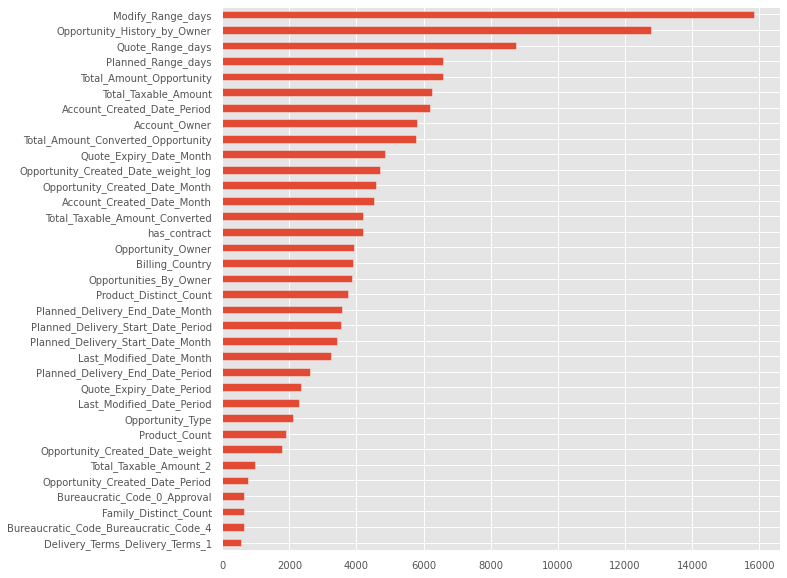

In [244]:
plot_feature_importance(np.array([est.feature_importances_ for est in scores_lgb["estimator"]]).mean(axis=0), features_kbest.columns)

In [245]:
# X_train.columns.value_counts()

____________

In [246]:
# features_val = df_val.drop(columns=["Opportunity_ID", "train"]).loc[:, kbest.get_support()]#.drop(columns=prod_cols)
features_val = df_val[X_train.columns]#.drop(columns=prod_cols)

answers = predict_proba_(scores_lgb["estimator"], features_val) #retrain with whole dataset

In [247]:
ids = df_val[["Opportunity_ID"]]

In [248]:
ids.loc[:, "proba1"] = answers

/home/jloscalzo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jloscalzo/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [249]:
from datetime import datetime
now = datetime.now().strftime("%Y%m%d_%H%M")
now

'20200626_1414'

In [250]:
ids.head()

,Opportunity_ID,proba1
16947,10689.0,0.987467
16948,10689.0,0.987467
16949,10689.0,0.987467
16950,10690.0,0.959720
16951,10690.0,0.965486


In [251]:
prediction_file = f'../data/results/lg_submit_{now}.csv'

In [252]:
ids = ids.groupby("Opportunity_ID")["proba1"].mean().reset_index()
ids.Opportunity_ID = ids.Opportunity_ID.astype('int')

In [253]:
ids[["Opportunity_ID", "proba1"]].to_csv(prediction_file, header=None, index=None)